<a href="https://colab.research.google.com/github/alxogm/tutorials/blob/master/getting_started/intro_to_DESI_EDR_files_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to DESI Early Data Release

*Ragadeepika Pucha (U.Arizona), Anthony Kremin (Berkeley Lab), Stéphanie Juneau (NOIRLab), Jaime E. Forero-Romero (Uniandes), Alma González (U. de Guanajuato) and DESI Data Team*

# Table of Contents

* [Overview](#overview)
* [Imports](#import)
* [Accessing the data](#data_access)
    * [Summary Files](#sumfiles)
    * [Redshift Catalogs](#zcatalog)
    * [Summary Redshift Catalogs](#summary_zcatalog)
    * [Healpix/ Directory](#hpx)
* [Accessing and Plotting Spectra of a Single Object](#spectra_access)
    * [Working with Coadded Spectra using desispec.io.read_spectra](#spectra)
* [References](#ref)

<a class="anchor" id="overview"></a>
# Overview

In this notebook, we will explore the DESI data file structure in the early data release (EDR). Information about the release can be found [here](https://data.desi.lbl.gov/doc/releases/). <br/>
The notebook shows how to access the different files in the data release, to access all the available spectra, along with the redshift information, for a given object, and to finally plot the "best" spectrum.

A list of technical papers describing the science, targeting and the survey design for the DESI experiment can be found [here](https://data.desi.lbl.gov/doc/papers/).

All links in this tutorial are public unless stated that they are **exclusive to DESI collaborators**.

### Bug Reporting
If you identify any errors please talk to me as this specific version of the tutorial is not yet in the main desihub repository.

### Getting Started

#### Using Colaboratory

The easiest way to get started would be to follow the [original tutorial](https://github.com/desihub/tutorials/blob/main/getting_started/intro_to_DESI_EDR_files.ipynb) for which you would use the jupyter server at NERSC so that you don't need to install any code or download any data locally.

Instead, we assume you do not have access to NERSC facilities, therefore we will do everything in Colaboratory. We will have to install some software and donwload files, so make sure you have enough space in your google Drive.

Lets start with all the preparations.

In [2]:
import os
import sys
from   google.colab import drive
import subprocess

In [3]:
# We will need fitsio library, unfortunately you have to install it everytime you restart the session
!pip install fitsio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fitsio: filename=fitsio-1.2.0-cp310-cp310-linux_x86_64.whl size=813108 sha256=888dcfffa9628f50b6d173e4e2472d5b56f390f402726c6bf410507843f153a7
  Stored in directory: /root/.cache/pip/wheels/22/a5/b3/80cef1ebc3dcec96a401600a2a4bd001f13c9f1f6254a65cc1
Successfully built fitsio


In [4]:
#Mount the Google Drive and define the directory in which you will be working
drivepath='/content/drive/'
drive.mount(drivepath, force_remount=True)
desiedr_path = drivepath + '/MyDrive/'+"desi_edr_test/"
desicode_path = desiedr_path+'/desicode'
specprod = 'fuji'    # Internal name for the EDR
specprod_dir = desiedr_path+specprod

Mounted at /content/drive/


In [5]:
#Uncomment the following lines to clone desicode if its the first time running this notebook

#os.makedirs(desiedr_path)
os.makedirs(specprod_dir)
os.makedirs(specprod_dir+'/zcatalog')
os.makedirs(specprod_dir+'/healpix')
os.makedirs(desicode_path)
os.chdir(desicode_path)
subprocess.run('git clone https://github.com/desihub/desitarget.git --depth=1', shell=True, check=True)
subprocess.run('git clone https://github.com/desihub/desiutil.git --depth=1', shell=True, check=True)
subprocess.run('git clone https://github.com/desihub/desispec.git --depth=1', shell=True, check=True)
subprocess.run('git clone https://github.com/desihub/desimodel.git --depth=1', shell=True, check=True)
subprocess.run('git clone https://github.com/desihub/speclite.git --depth=1', shell=True, check=True)


CompletedProcess(args='git clone https://github.com/desihub/speclite.git --depth=1', returncode=0)

In [6]:
#This lines adds the code paths to the main path, to look for the relevan libraries, so we don't have to actually install the code
sys.path.insert(1,desicode_path+"/desitarget/py/")
sys.path.insert(1,desicode_path+"/desiutil/py/")
sys.path.insert(1,desicode_path+"/desispec/py/")
sys.path.insert(1,desicode_path+"/desimodel/py/")
sys.path.insert(1,desicode_path+'/speclite/')

<a class="anchor" id="import"></a>
# Imports

In [7]:
# import some helpful python packages
import os
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib
import matplotlib.pyplot as plt

#plt.style.use('../mpl/desi.mplstyle')

In [8]:
# import DESI related modules -
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

# DESI targeting masks -
from desitarget.sv1 import sv1_targetmask    # For SV1
from desitarget.sv2 import sv2_targetmask    # For SV2
from desitarget.sv3 import sv3_targetmask    # For SV3

<a class="anchor" id="data_access"></a>
# Accessing the data

The DESI Early Data Release (EDR) consists some of the commissioning data, as well as the whole of the survey validation (SV) data. This includes SV1, SV2, and SV3 (1% survey).
Information about the SV data can be found [here](https://data.desi.lbl.gov/doc/).

For the EDR data, the spectra are divided by the `SURVEY` (sv1/sv2/sv3) they were observed in. The observing conditions (dark or bright), called as `PROGRAM` in the DESI terminology, is used to categorize the spectra further.

In [9]:
import urllib.request
# Release directory path

#specprod = "fuji"    # Internal name for the EDR
#specprod_dir = "/global/cfs/cdirs/desi/public/edr/spectro/redux/fuji/"
catalog_url= "https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/zcatalog/"
base_url= "https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/"

zcat_pix= "zall-pix-fuji.fits"
tiles = "tiles-fuji.fits"
exposures= "exposures-fuji.fits"
local_zcat_pix = os.path.join(desiedr_path+'/fuji/zcatalog/',zcat_pix)
local_tiles = os.path.join(desiedr_path+'/fuji/',tiles)
local_exposures =  os.path.join(desiedr_path+'/fuji/',exposures)

if not os.path.exists(local_tiles):
        #os.makedirs(desiedr_path+'/fuji/zcatalog/')
        print("downloading Tile file from %s to %s"
              % (base_url+tiles, local_tiles ))
        tmp = urllib.request.urlretrieve(base_url+tiles,local_tiles)
        print ("Downloaded file"+local_tiles )
else:
    print("%s already exist"%(local_tiles))

if not os.path.exists(local_exposures ):
        print("downloading Tile file from %s to %s"
              % (base_url+exposures, local_exposures ))
        tmp = urllib.request.urlretrieve(base_url+exposures, local_exposures)
        print ("Downloaded file"+local_exposures )
else:
    print("%s already exist"%(local_exposures))


if not os.path.exists(local_zcat_pix):
        #os.makedirs(desiedr_path+'/fuji/zcatalog/')
        print("downloading DESI catalog from %s to %s"
              % (catalog_url+zcat_pix, local_zcat_pix ))
        tmp = urllib.request.urlretrieve(catalog_url+zcat_pix,local_zcat_pix)
        print ("Downloaded file"+local_zcat_pix)
else:
    print("%s already exist"%(local_zcat_pix))

downloading Tile file from https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/tiles-fuji.fits to /content/drive//MyDrive/desi_edr_test//fuji/tiles-fuji.fits
Downloaded file/content/drive//MyDrive/desi_edr_test//fuji/tiles-fuji.fits
downloading Tile file from https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/exposures-fuji.fits to /content/drive//MyDrive/desi_edr_test//fuji/exposures-fuji.fits
Downloaded file/content/drive//MyDrive/desi_edr_test//fuji/exposures-fuji.fits
downloading DESI catalog from https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/zcatalog/zall-pix-fuji.fits to /content/drive//MyDrive/desi_edr_test//fuji/zcatalog/zall-pix-fuji.fits
Downloaded file/content/drive//MyDrive/desi_edr_test//fuji/zcatalog/zall-pix-fuji.fits


In [10]:
# List everything in this directory, there should be all
# necesary files needed for running this notebook,
#however you can list all available files here: https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/
os.listdir(specprod_dir)

['zcatalog', 'healpix', 'tiles-fuji.fits', 'exposures-fuji.fits']

### Important files to Note:

1. tiles-fuji.fits (or .csv) -- This contains information about the observed tiles.
2. exposures-fuji.fits (or .csv) -- This consists of information about individual exposures of the targets.
3. zcatalog/ Directory -- This directory contains the (to be) downloaded redshift catalogs .
4. tiles/ Directory -- This directory will hold the (to be) downloaded per-tile coadds and redshifts, in various flavors.
5. healpix/ Directory -- This directory will hold all the (to be) donwloaded coadds and redshifts based on sky location (healpix).

<a class="anchor" id="sumfiles"></a>
## Summary Files

Let's first take a look at the tiles and exposure summary files.

### tiles-fuji.fits
This file tells you what tiles were observed, what `SURVEY` and `PROGRAM` they were observed for, some observing conditions, and three estimates of the "effective time" (in seconds) that each tile acquired. The time estimate used for survey operations decisions is `EFFTIME_SPEC`. The datamodel for this table is described [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/tiles-SPECPROD.html).

In [11]:
tiles_table = Table.read(f'{specprod_dir}/tiles-{specprod}.fits',)
print(f"Tiles table columns: {tiles_table.colnames}")

Tiles table columns: ['TILEID', 'SURVEY', 'PROGRAM', 'FAPRGRM', 'FAFLAVOR', 'NEXP', 'EXPTIME', 'TILERA', 'TILEDEC', 'EFFTIME_ETC', 'EFFTIME_SPEC', 'EFFTIME_GFA', 'GOALTIME', 'OBSSTATUS', 'LRG_EFFTIME_DARK', 'ELG_EFFTIME_DARK', 'BGS_EFFTIME_BRIGHT', 'LYA_EFFTIME_DARK', 'GOALTYPE', 'MINTFRAC', 'LASTNIGHT']


In [12]:
tiles_table[0:5]

TILEID,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,NEXP,EXPTIME,TILERA,TILEDEC,EFFTIME_ETC,EFFTIME_SPEC,EFFTIME_GFA,GOALTIME,OBSSTATUS,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GOALTYPE,MINTFRAC,LASTNIGHT
int32,bytes20,bytes6,bytes20,bytes20,int64,float64,float64,float64,float64,float64,float64,float64,bytes20,float64,float64,float64,float64,bytes20,float64,int32
80615,cmx,other,m33,cmxm33,4,3600.1,24.027,31.39,0.0,3390.9,0.0,1000.0,obsend,3361.7,3390.9,3320.2,3878.6,other,0.9,20201216
80609,sv1,dark,lrgqso,cmxlrgqso,15,13500.7,150.12,2.206,0.0,7828.3,0.0,4000.0,obsstart,7847.0,7828.3,8057.3,10707.3,dark,0.9,20201217
80607,sv1,dark,lrgqso,cmxlrgqso,15,13500.8,106.74,56.1,0.0,9374.2,0.0,4000.0,obsstart,8794.6,9374.2,8553.9,8541.1,dark,0.9,20201219
80606,sv1,dark,elg,cmxelg,12,10800.7,36.448,-4.501,0.0,6699.4,0.0,4000.0,obsstart,6555.6,6699.4,6583.6,7397.5,dark,0.9,20201219
80620,sv1,dark,lrgqso,sv1lrgqso,9,8100.5,144.0,65.0,0.0,7128.7,0.0,4000.0,obsstart,6643.9,7128.7,6299.8,6316.1,dark,0.9,20201221


Let's use this to find the number of tiles in each SURVEY and each PROGRAM.

In [13]:
for survey in ['cmx', 'sv1', 'sv2', 'sv3']:
    print(f'{survey}: Ntiles = {np.sum(tiles_table["SURVEY"]==survey)}')

cmx: Ntiles = 1
sv1: Ntiles = 188
sv2: Ntiles = 39
sv3: Ntiles = 488


In [14]:
for program in ['bright', 'dark']:
    print(f'{program}: Ntiles = {np.sum(tiles_table["PROGRAM"]==program)}')

bright: Ntiles = 282
dark: Ntiles = 355


### exposures-fuji.fits
This file is primarily used for daily operations, but can be handy for looking at individual exposures and the amount of "EFFECTIVE TIME" that exposure acquired. <br/>
The datamodel for this file is available [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/exposures-SPECPROD.html).

In [15]:
exp_table = Table.read(f'{specprod_dir}/exposures-{specprod}.fits', hdu='EXPOSURES')
print(f"Tiles table columns: {exp_table.colnames}")

Tiles table columns: ['NIGHT', 'EXPID', 'TILEID', 'TILERA', 'TILEDEC', 'MJD', 'SURVEY', 'PROGRAM', 'FAPRGRM', 'FAFLAVOR', 'EXPTIME', 'EFFTIME_SPEC', 'GOALTIME', 'GOALTYPE', 'MINTFRAC', 'AIRMASS', 'EBV', 'SEEING_ETC', 'EFFTIME_ETC', 'TSNR2_ELG', 'TSNR2_QSO', 'TSNR2_LRG', 'TSNR2_LYA', 'TSNR2_BGS', 'TSNR2_GPBDARK', 'TSNR2_GPBBRIGHT', 'TSNR2_GPBBACKUP', 'LRG_EFFTIME_DARK', 'ELG_EFFTIME_DARK', 'BGS_EFFTIME_BRIGHT', 'LYA_EFFTIME_DARK', 'GPB_EFFTIME_DARK', 'GPB_EFFTIME_BRIGHT', 'GPB_EFFTIME_BACKUP', 'TRANSPARENCY_GFA', 'SEEING_GFA', 'FIBER_FRACFLUX_GFA', 'FIBER_FRACFLUX_ELG_GFA', 'FIBER_FRACFLUX_BGS_GFA', 'FIBERFAC_GFA', 'FIBERFAC_ELG_GFA', 'FIBERFAC_BGS_GFA', 'AIRMASS_GFA', 'SKY_MAG_AB_GFA', 'SKY_MAG_G_SPEC', 'SKY_MAG_R_SPEC', 'SKY_MAG_Z_SPEC', 'EFFTIME_GFA', 'EFFTIME_DARK_GFA', 'EFFTIME_BRIGHT_GFA', 'EFFTIME_BACKUP_GFA']


In [16]:
exp_table[-5:]

NIGHT,EXPID,TILEID,TILERA,TILEDEC,MJD,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,EXPTIME,EFFTIME_SPEC,GOALTIME,GOALTYPE,MINTFRAC,AIRMASS,EBV,SEEING_ETC,EFFTIME_ETC,TSNR2_ELG,TSNR2_QSO,TSNR2_LRG,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBDARK,TSNR2_GPBBRIGHT,TSNR2_GPBBACKUP,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GPB_EFFTIME_DARK,GPB_EFFTIME_BRIGHT,GPB_EFFTIME_BACKUP,TRANSPARENCY_GFA,SEEING_GFA,FIBER_FRACFLUX_GFA,FIBER_FRACFLUX_ELG_GFA,FIBER_FRACFLUX_BGS_GFA,FIBERFAC_GFA,FIBERFAC_ELG_GFA,FIBERFAC_BGS_GFA,AIRMASS_GFA,SKY_MAG_AB_GFA,SKY_MAG_G_SPEC,SKY_MAG_R_SPEC,SKY_MAG_Z_SPEC,EFFTIME_GFA,EFFTIME_DARK_GFA,EFFTIME_BRIGHT_GFA,EFFTIME_BACKUP_GFA
int32,int32,int32,float64,float64,float64,bytes7,bytes6,bytes16,bytes19,float64,float64,float64,bytes6,float64,float32,float64,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20210529,90247,373,245.832,43.335,59364.36430717,sv3,bright,bright,sv3bright,1117.044921875,337.6169128417969,220.0,bright,0.9,1.068032,0.009423913434147835,1.4692250490188599,223.98949,44.475147,8.6310425,27.963772,13.32962854905054,2411.5493,2913.2263,571.0539,3861.4192,344.7333,382.4863,337.6169,152.48772523755858,252.18994,299.93616,283.0008,1.033268169456845,1.5989511114379837,0.3463963950802347,0.2711160875582591,0.13095087611297396,0.5744627241541538,0.6178762888349207,0.6495438397604425,1.0794371013994377,20.525505155668775,20.297341392770107,20.449208280154785,19.76493542876646,302.50769913715436,253.50730817203686,302.50769913715436,273.4625058258671
20210529,90248,400,252.442,34.39,59364.37940271,sv3,bright,bright,sv3bright,939.0352783203125,324.3939208984375,220.0,bright,0.9,1.048001,0.02507576160132885,1.29488205909729,223.24913,42.884575,8.598594,26.822409,13.778553664730861,2317.0994,2856.3599,555.2721,3844.6543,330.66275,368.80737,324.39392,157.62331993475487,247.26717,291.64703,281.7721,1.0140228921898826,1.457591698451905,0.40184047540259993,0.30849427371325466,0.14702371651459745,0.6728532105171252,0.7109799191994934,0.7364581942095623,1.0582610372774308,20.471386857019684,20.238753596063795,20.384506599404546,19.781617847518657,290.8780128434468,247.4650862587995,290.8780128434468,288.78444084042695
20210529,90249,427,269.538,65.929,59364.39286466,sv3,bright,bright,sv3bright,638.1410522460938,305.1478576660156,220.0,bright,0.9,1.210807,0.03996047377586365,1.233667016029358,222.87892,40.401855,9.118238,25.374088,12.912202950241044,2179.6274,2848.7534,533.6405,4032.643,312.80807,347.45596,305.14786,147.71247739144215,246.60869,280.28543,295.54968,1.0477574055550516,1.08992566816822,0.5676842869416672,0.41038684882798,0.18894336064826067,0.9630449341670511,0.9581835389545319,0.9601785625345641,1.213112847568369,20.346008656681235,20.16165043687451,20.307942291873115,19.595014353283528,282.96405063110075,247.82334776412873,282.96405063110075,360.81216722111327
20210529,90250,565,269.926,62.441,59364.40219283,sv3,bright,bright,sv3bright,523.5750122070312,301.34124755859375,220.0,bright,0.9,1.170556,0.031614355742931366,1.1474930047988892,222.65558,40.03024,9.407354,24.999666,15.261678844550625,2152.4375,2863.223,528.574,4095.7031,308.19223,344.26007,301.34125,174.58991312083205,247.86128,277.62433,300.1713,1.0429984187389545,0.9969984126737262,0.6200876372740602,0.44224438682694484,0.20191861148396323,1.0563439920369584,1.0352732075685347,1.0277561394185621,1.173014299261516,20.36560251288922,20.187495833922565,20.329918150146984,19.650058927549892,275.4071756801791,242.9241353658027,275.4071756801791,374.1056713204288
20210610,93262,521,212.891,-0.679,59376.20555175,sv3,dark,dark,sv3dark,1378.7406005859375,1226.9554443359375,1200.0,dark,0.9,1.203036,0.0666235014796257,1.0793989896774292,1211.8282,142.66924,35.086723,104.27875,94.79930891506373,8636.729,14916.666,2550.5806,14568.3

Let's use this to find the number of exposures in each `SURVEY` and each `PROGRAM`.

In [17]:
for survey in ['cmx', 'sv1', 'sv2', 'sv3']:
    print(f'{survey}: Nexps={np.sum(exp_table["SURVEY"]==survey)}')

cmx: Nexps=4
sv1: Nexps=1673
sv2: Nexps=72
sv3: Nexps=710


In [18]:
for program in ['bright', 'dark']:
    print(f'{program}: Nexps={np.sum(exp_table["PROGRAM"]==program)}')

bright: Nexps=897
dark: Nexps=1194


<a class="anchor" id="zcatalog"></a>

## Redshift Catalogs

The redshift catalogs that are in the `zcatalog/` directory are divided into `zpix` and `ztile` files. The `zpix` files have the format: `zpix-{survey}-{program}.fits`, while the `ztile` have the format: `ztile-{survey}-{program}-{group}.fits`. The datamodel for the different files within this folder can be found [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/index.html). Each of these files contain redshift and targeting information of the sources based on how their spectra are coadded.

* **survey**: SURVEY that the target was observed in. This can be sv1, sv2, or main.
* **program**: FIBER ASSIGNMENT PROGRAM. This is the planned observing conditions for the target. It can be dark or bright or backup. In case of cmx and sv1, there is 'other' as well.
* **group**: This denotes what type of coadd. It can be perexp, pernight, or cumulative.

For example, `zpix-sv1-dark.fits` contains information about the targets that were observed in SV1 for the _dark_ program. Since it is healpix based, the resulting spectra for a particular target is the coadded spectra across all tiles that were observed within the given `SURVEY` and `PROGRAM`. This will provide the highest S/N version of each target.

Note that some of the targets were observed in multiple surveys and/or programs. In such cases, one may want to select the _PRIMARY_ spectrum of a given object. This information is available in the redshift summary catalogs, which will be explained in detail below.

In [19]:
# Listing all the available redshift catalogs

os.listdir(f'{specprod_dir}/zcatalog')

['zall-pix-fuji.fits']

Now, we will look at the summary redshift catalogs that contain the `PRIMARY` spectra information

<a class="anchor" id="summary_zcatalog"></a>
## Summary Redshift Catalogs

There are two summary redshift catalogs: <br/>
**zall-pix-fuji.fits** <br/>
This is a stack of all the healpix-based redshift catalogs, including all surveys and programs. The datamodel is [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-pix-SPECPROD.html). <br/>
**zall-tilecumulative-fuji.fits** <br/>
This is a stack of all the tile-based cumulative redshift catalogs, including all surveys and programs. The datamodel is [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-tilecumulative-SPECPROD.html).

For both these summary catalogs, all the columns in the original catalogs ([zpix-SURVEY-PROGRAM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html) and [ztile-SURVEY-PROGRAM-GROUPTYPE.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html)) are included. <br/>
Four new columns are added:

1. SV_NSPEC - Number of SV spectra available of each target.
2. SV_PRIMARY - PRIMARY flag for the sources with SV spectra.
3. ZCAT_NSPEC - Number of spectra available in the entire catalog of each target.
4. ZCAT_PRIMARY - PRIMARY flag for the sources in the entire catalog.

### Tile-based vs healpix-based
The choice of which you use will depend on your specific science case. If you want the hightest S/N spectra then you'll likely want to use healpix based redshifts. If you want a more consistant observing depth among the redshfits in your sample, or you need objects that fit on a single pointing, then tile redshifts may be of more
interest.

We will focus here on the healpix based redshifts.

### Working with the zall-pix file

In [20]:
zpix_cat = Table.read(f'{specprod_dir}/zcatalog/zall-pix-{specprod}.fits', hdu="ZCATALOG")

In [21]:
print(zpix_cat.columns)

<TableColumns names=('TARGETID','SURVEY','PROGRAM','HEALPIX','SPGRPVAL','Z','ZERR','ZWARN','CHI2','COEFF','NPIXELS','SPECTYPE','SUBTYPE','NCOEFF','DELTACHI2','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','PMRA','PMDEC','REF_EPOCH','FA_TARGET','FA_TYPE','OBJTYPE','SUBPRIORITY','OBSCONDITIONS','RELEASE','BRICKNAME','BRICKID','BRICK_OBJID','MORPHTYPE','EBV','FLUX_G','FLUX_R','FLUX_Z','FLUX_W1','FLUX_W2','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','FLUX_IVAR_W1','FLUX_IVAR_W2','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','MASKBITS','SERSIC','SHAPE_R','SHAPE_E1','SHAPE_E2','REF_ID','REF_CAT','GAIA_PHOT_G_MEAN_MAG','GAIA_PHOT_BP_MEAN_MAG','GAIA_PHOT_RP_MEAN_MAG','PARALLAX','PHOTSYS','PRIORITY_INIT','NUMOBS_INIT','CMX_TARGET','DESI_TARGET','BGS_TARGET','MWS_TARGET','SCND_TARGET','SV1_DESI_TARGET','SV1_BGS_TARGET','SV1_MWS_TARGET','SV1_SCND_TARGET','SV2_DESI_TARGET','SV2_BGS_TARGET','SV2_MWS_TARGET','SV2_SCND_TARGET','SV3_DESI_TARGET','SV3_BGS_TARGE

In [22]:
zpix_cat[0:5]

TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bool,int64,bool
616089230757593610,cmx,other,2152,2152,1.0791710884059862,8.043609933906356e-05,5,8196.955931693316,-31.270945382111947 .. -4.304250468199833,7928,GALAXY,--,10,8.043657064437866,0,23.914121939862518,29.974787585945496,0.0,0.0,0.0,4294967296,4,SKY,0.8476382465505894,63,9010,0240p300,495765,522,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-0.003990191,0.026369713,0.0027650434,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,--,0.0,0.0,0.0,0.0,--,-1,-1,4294967296,4294967296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.914121939862518,29.974787585945496,4,3600.0,1,1,-0.004,0.008336666,-0.00275,0.009987492,23.914140396147115,0.14040637,29.974777243955057,0.12941206,0.793052,639.917,0.3878204,121.14421,339.00644,2058.3599,832.6921,10.254479,3.4988468,43286.7,93.85132,7782.0195,0.16086136,8970.089,47104.805,28.528677,136.52605,5.594912e-05,293.99265,1.0618171e-05,0.0,13069.495,7.403538e-05,60.08052,135.6212,43926.617,388.23178,7903.1636,339.1673,24097.945,47937.496,98.86368,275.6461,0,False,1,True
39628473202904408,cmx,other,2152,2152,0.18041222201570103,8.931818686229672e-06,0,12949.879635035992,-109.46447587943996 .. 12.118995244141198,7926,GALAXY,--,10,8801.990980923176,0,24.04010479193436,29.813362596941825,0.0,0.0,2020.9597,72057594037929216,1,TGT,0.6306843567905966,7,9010,--,494513,3416,DEV,0.047077972,6.2664,17.88001,40.539513,59.783627,50.919693,533.2463,113.88678,26.52623,-1.0,-1.0,2.5057633,7.149731,16.210651,2.5057633,7.149731,16.210651,0,4.0,0.96060556,-0.2916907,-0.14283308,0,--,0.0,0.0,0.0,0.0,S,32

### Selecting sources based on Targeting Information

There are five main target types used in DESI:
1. Milky Way Survey (MWS)
2. Bright Galaxy Survey (BGS)
3. Luminous Red Galaxies (LRG)
4. Emission Line Galaxies (ELG)
5. Quasars (QSO).

Information about how these targets are selected are available separately for [SV1](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SurveyValidation), [SV2](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV2), and [SV3](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV3) (**links exclusive to DESI collaborators**). Based on the tests on SV data, the finalized target selection for the main survey is available [in this paper](https://ui.adsabs.harvard.edu/abs/2023AJ....165...50M/abstract). <br/>
**To-do: Add public links to SV target selection when available**

In [23]:
# Targetting bits are coded in the sv*_targetmask.desi_mask
## The long list of targeting reflects the complexity of the targeting process and helps in subselecting from the main target types.

sv1_targetmask.desi_mask

sv1_desi_mask:
  - [LRG,              0, "LRG", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200}, 'numobs': 2}]
  - [ELG,              1, "ELG", {'obsconditions': 'DARK|GRAY', 'priorities': {'UNOBS': 3000, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3000, 'MORE_ZGOOD': 3000}, 'numobs': 1}]
  - [QSO,              2, "QSO", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3400, 'MORE_ZGOOD': 3350, 'MORE_ZWARN': 3300, 'MORE_MIDZQSO': 100, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0}, 'numobs': 4}]
  - [LRG_OPT,          3, "LRG from baseline version of optical cuts", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200}, 'numobs': 4}]
  - [LRG_IR,           4, "LRG from baseline version of IR cuts", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MO

In [24]:
# A simple example of using the bitmasks

print(sv1_targetmask.desi_mask.mask("STD_FAINT"), sv1_targetmask.desi_mask.mask("STD_BRIGHT"), sv1_targetmask.desi_mask.mask("STD_FAINT|STD_BRIGHT"))
print(2**33, 2**35, 2**33 + 2**35)

8589934592 34359738368 42949672960
8589934592 34359738368 42949672960


In [25]:
# Targeting information about the DESI targetting is stored in the different desi_target columns
# sv1_targetmask.desi_mask corresponds to SV1_DESI_TARGET
# sv2_targetmask.desi_mask corresponds to SV2_DESI_TARGET
# sv3_targetmask.desi_mask corresponds to SV3_DESI_TARGET

sv1_desi_tgt = zpix_cat['SV1_DESI_TARGET']
sv2_desi_tgt = zpix_cat['SV2_DESI_TARGET']
sv3_desi_tgt = zpix_cat['SV3_DESI_TARGET']

sv1_desi_mask = sv1_targetmask.desi_mask
sv2_desi_mask = sv2_targetmask.desi_mask
sv3_desi_mask = sv3_targetmask.desi_mask

In [26]:
# Selecting candidates -
# The code below selects the individual targets observed in all the SV1, SV2, and SV3 tiles.

## All BGS targets from sv1, sv2, and sv3
is_bgs = (sv1_desi_tgt & sv1_desi_mask['BGS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['BGS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['BGS_ANY'] != 0)
## All LRG targets from sv1, sv2, and sv3
is_lrg = (sv1_desi_tgt & sv1_desi_mask['LRG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['LRG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['LRG'] != 0)
## All ELG targets from sv1, sv2, and sv3
is_elg = (sv1_desi_tgt & sv1_desi_mask['ELG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['ELG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['ELG'] != 0)
## All QSO targets from sv1, sv2, and sv3
is_qso = (sv1_desi_tgt & sv1_desi_mask['QSO'] != 0)|(sv2_desi_tgt & sv2_desi_mask['QSO'] != 0)|(sv3_desi_tgt & sv3_desi_mask['QSO'] != 0)
## All MWS targets from sv1, sv2, and sv3
is_mws = (sv1_desi_tgt & sv1_desi_mask['MWS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['MWS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['MWS_ANY'] != 0)
## All Secondary targets from sv1, sv2, and sv3
is_scnd = (sv1_desi_tgt & sv1_desi_mask['SCND_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['SCND_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['SCND_ANY'] != 0)

In [27]:
# Number of sources of each target type
n_bgs = len(zpix_cat[is_bgs])
n_lrg = len(zpix_cat[is_lrg])
n_elg = len(zpix_cat[is_elg])
n_qso = len(zpix_cat[is_qso])
n_mws = len(zpix_cat[is_mws])
n_scnd = len(zpix_cat[is_scnd])

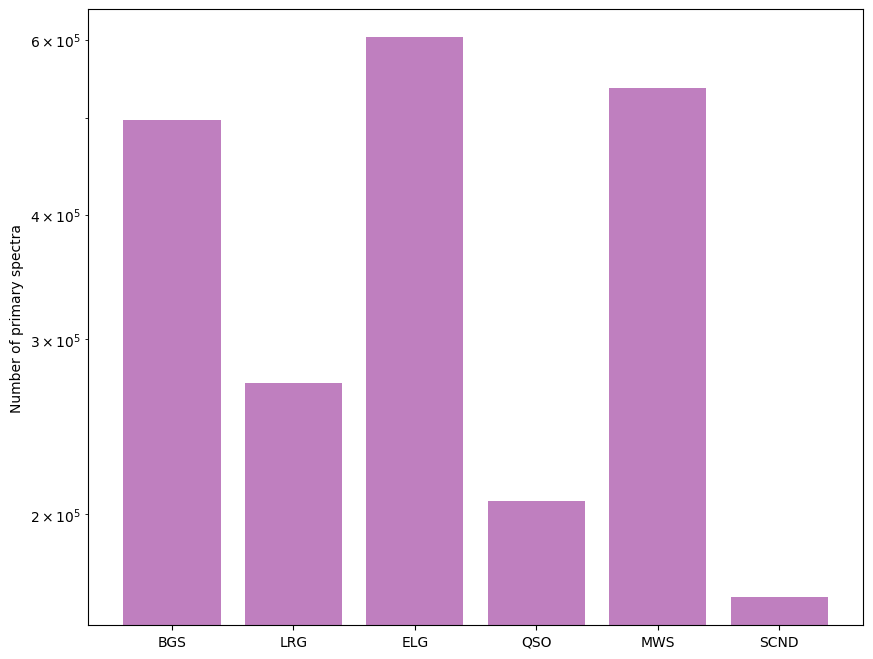

In [29]:
# Let us look at the numbers visually -

plt.figure(figsize = (10, 8))

targets = ['BGS', 'LRG', 'ELG', 'QSO', 'MWS', 'SCND']
numbers = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]

plt.bar(targets, numbers, color = 'purple', alpha = 0.5)
plt.ylabel('Number of primary spectra')
plt.yscale('log')

Text(0.5, 0, 'Redshift')

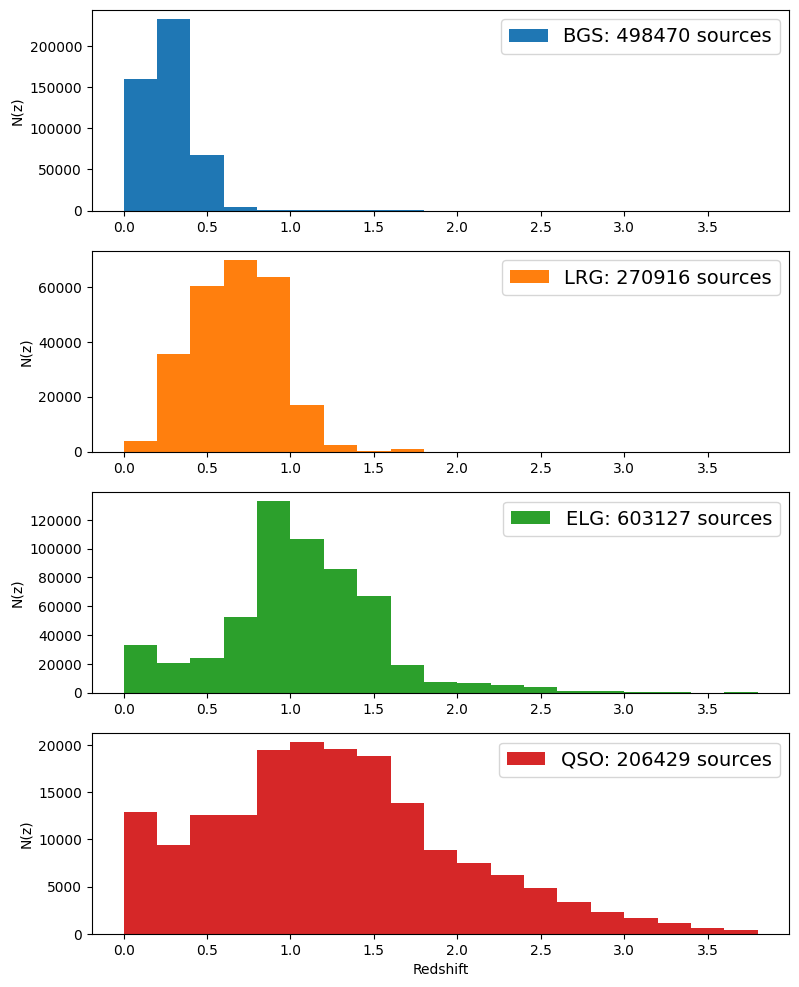

In [30]:
# Now let us look at the distribution of redshifts -

fig, axs = plt.subplots(4, 1, figsize = (9, 12))
bins = np.arange(0, 4, 0.2)

axs[0].hist(zpix_cat['Z'][is_bgs], color = 'C0', bins = bins, label = f'BGS: {n_bgs} sources')
axs[0].legend(fontsize = 14)
axs[0].set_ylabel("N(z)")
axs[1].hist(zpix_cat['Z'][is_lrg], color = 'C1', bins = bins, label = f'LRG: {n_lrg} sources')
axs[1].legend(fontsize = 14)
axs[1].set_ylabel("N(z)")
axs[2].hist(zpix_cat['Z'][is_elg], color = 'C2', bins = bins, label = f'ELG: {n_elg} sources')
axs[2].legend(fontsize = 14)
axs[2].set_ylabel("N(z)")
axs[3].hist(zpix_cat['Z'][is_qso], color = 'C3', bins = bins, label = f'QSO: {n_qso} sources')
axs[3].legend(fontsize = 14)
axs[3].set_ylabel("N(z)")
axs[3].set_xlabel("Redshift")


#### Other masks

`desi_mask` consists of the uppermost level targeting information in DESI. However, there can be sub-classes of targets. For example, BGS have different target masks depending on the selection criterion. Each of the different secondary target proposals have their own masks. They can be selected in a similar way as above, but with the respective columns in the redshift catalog. More information about Bitmasks in DESI is available [here](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html).

In [31]:
sv1_targetmask.bgs_mask.names

<bound method BitMask.names of sv1_bgs_mask:
  - [BGS_FAINT,        0, "BGS faint targets", {'obsconditions': 'BRIGHT|GRAY|DARK', 'priorities': {'UNOBS': 2000, 'MORE_ZWARN': 2000, 'MORE_ZGOOD': 1000, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0}, 'numobs': 1}]
  - [BGS_BRIGHT,       1, "BGS bright targets", {'obsconditions': 'BRIGHT', 'priorities': {'UNOBS': 2100, 'MORE_ZWARN': 2100, 'MORE_ZGOOD': 1000, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0}, 'numobs': 1}]
  - [BGS_FAINT_EXT,    2, "BGS faint extended targets", {'obsconditions': 'BRIGHT', 'priorities': {'UNOBS': 2000, 'MORE_ZWARN': 2000, 'MORE_ZGOOD': 1000, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0}, 'numobs': 1}]
  - [BGS_LOWQ,         3, "BGS low quality targets", {'obsconditions': 'BRIGHT', 'priorities': {'UNOBS': 2000, 'MORE_ZWARN': 2000, 'MORE_ZGOOD': 1000, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0}, 'numobs': 1}]
  - [BGS_FIBMAG,       4, "BGS fiber magnitude targets", {'obsconditions': 'BRIGHT', 'priorities': {'UNOBS': 2000, 'MORE_ZWARN': 

In [32]:
sv1_targetmask.scnd_mask.names

<bound method BitMask.names of sv1_scnd_mask:
  - [VETO,             0, "Never observe, even if a primary target bit is set", {'obsconditions': 'DARK|GRAY|BRIGHT|BACKUP|TWILIGHT12|TWILIGHT18', 'filename': 'veto', 'flavor': 'SPARE', 'downsample': 1, 'priorities': {'UNOBS': 0, 'DONE': 0, 'OBS': 0, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 0, 'MORE_ZGOOD': 0}, 'numobs': 1}]
  - [UDG,              1, "See $SCND_DIR/sv1/docs/UDG.txt", {'obsconditions': 'DARK', 'filename': 'UDG', 'flavor': 'SPARE', 'downsample': 1, 'priorities': {'UNOBS': 1900, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 1900, 'MORE_ZGOOD': 1900}, 'numobs': 100}]
  - [FIRST_MALS,       2, "See $SCND_DIR/sv1/docs/FIRST_MALS.txt", {'obsconditions': 'DARK', 'filename': 'FIRST_MALS', 'flavor': 'SPARE', 'downsample': 1, 'priorities': {'UNOBS': 1025, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 1025, 'MORE_ZGOOD': 1025}, 'numobs': 100}]
  - [QSO_RED,          5, "See $SCND_DIR/sv1/docs/QSO_RED.ipynb", {'obsconditions': '

Now, we will explore the Healpix/ directory and see how to access the required coadded spectra

<a class="anchor" id="hpx"></a>
## Healpix/ Directory

This directory divides the coadded spectra of targets based on the healpix number and the observing conditions (dark/bright).

In [33]:
healpix_dir = f'{specprod_dir}/healpix'

The directories in `healpix` folder are divided based on the `SURVEY` and then by the `PROGRAM` (dark or bright or backup).

In [35]:
# Define survey and program here -
survey = 'sv1'
program = 'bright'

<a class="anchor" id="spectra_access"></a>
# Accessing and Plotting Spectra of a Single Object

Under the healpix/ directory, the different healpix directories are grouped together in healpix subgroups.

To access a particular coadded spectra, we need the following information:

* **survey**: SURVEY that the target was observed in. This can be sv1, sv2, or sv3.
* **program**: FIBER ASSIGNMENT PROGRAM. This is the planned observing conditions for the target. It can be dark or bright or backup. In the case of sv1, we also have "other".
* **healpix**: HEALPIX Number, which depends on the position of the object in the sky.

The coadd filepath can be created using this -
```
{healpix_directory}/{survey}/{program}/{healpix_group}/{healpix}/coadd-{survey}-{program}-{healpix}.fits
```
The healpix group can be derived from the healpix number.

In [38]:
# Selecting a random object which has multiple spectra in DESI
sel = (zpix_cat['ZCAT_NSPEC'] >= 4)
targets = zpix_cat[sel]['TARGETID']

## Selecting random TARGETID from these targets
ii = 13
targetid = targets[ii]

In [39]:
# Selecting the redshift catalogs rows for the particular targetid
rows = zpix_cat['TARGETID'] == targetid
zcat_sel = zpix_cat[rows]

In [40]:
zcat_sel

TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bool,int64,bool
39628443939243162,sv1,bright,10400,10400,0.00017576862390758952,5.9267818867464456e-06,0,8395.399734615297,2563.826475269078 .. 0.0,7930,STAR,G,5,7094.939891020906,0,193.9630600779469,28.184801279429227,-10.969606,-5.9821224,2021.0034,2305843017803628544,3,TGT,0.9268149959802187,7,9010,1940p282,487536,1178,PSF,0.010675868,27.013937,36.19005,39.50774,10.627269,10.84989,268.49142,122.08833,86.26726,3.6678493,0.840744,20.961132,28.08122,30.655542,20.96117,28.081314,30.655718,0,0.0,0.0,0.0,0.0,1463781960361984000,G2,18.66126,18.951185,18.256508,-0.09954313,S,1100,1,0,0,0,0,0,2305843017803628544,0,33,0,0,0,0,0,0,0,0,0,193.9630600779469,28.184801279429227,15,6695.1265,7,1,-0.0022666666,0.009172423,-0.0019333333,0.008652553,193.9630499529053,0.16052763,28.18480907362125,0.11895433,0.789,244.84537,0.123466745,48.201504,95.5509,711.8767,380.18463,3.2498014,1.2666677,13767.155,31.48904,2623.146,0.051719077,2991.867,19035.857,9.300201,44.73422,2.1913993e-05,106.01278,4.284042e-06,0.0,5291.0586,3.3297718e-05,22.45411,50.998848,14012.001,137.62529,2671.3474,95.60262,8994.803,19416.043,35.004112,96.99973,5,False,5,False
39628443939243162,sv1,dark,10400,10400,0.00018887824977913167,3.7447705312619403e-06,0,9589.082127237343,2591.7496942327753 .. 0.0,7929,STAR,G,5,21353.29791857957,0,193.96306004967184,28.18480126503742,-10.969606,-5.9821224,2021.0116,2305843017803628544,3,TGT,0.3767977553817017,7,9010,1940p282,487536,1178,PSF,0.010675868,27.013937,36.19005,39.50774,10.627269,10.84989,268.49142,1

In [41]:
# Defining healpix, survey, and program variables for this target

survey_col = zcat_sel['SURVEY'].astype(str)
program_col = zcat_sel['PROGRAM'].astype(str)
hpx_col = zcat_sel['HEALPIX']

# Selecting the primary spectra -
is_primary = zcat_sel['ZCAT_PRIMARY']

# Information needed to access the spectra
survey = survey_col[is_primary][0]
program = program_col[is_primary][0]
hpx = hpx_col[is_primary][0]    ## This is same for all the rows, given its the same TARGET. But, just to be consistent.

# Let us explore the target directory
# Note that the target directory is different for the different spectra.
# We first explore the primary spectra and look at the other spectra later.
tgt_dir = f'{healpix_dir}/{survey}/{program}/{hpx//100}/{hpx}'
print(tgt_dir)

/content/drive//MyDrive/desi_edr_test/fuji/healpix/sv1/dark/104/10400


In [47]:
def get_spec_data_url(hpx,survey,program,redrock=False):
    specprod_dir = f"https://data.desi.lbl.gov/public/edr/spectro/redux/{specprod}"
    target_dir   = f"/healpix/{survey}/{program}/{hpx.astype(str)[:-2]}/{hpx}/"
    coadd_fname  = f"coadd-{survey}-{program}-{hpx}.fits"

    #Download the spectra file to the drive directory mantaining the same structure directory
    if not os.path.exists(desiedr_path+'/fuji'+target_dir):
      os.makedirs(desiedr_path+'/fuji'+target_dir)

    coadd_url = specprod_dir+target_dir+coadd_fname
    coadd_file=desiedr_path+'/fuji'+target_dir+coadd_fname

    if not os.path.exists(coadd_file):
        print("downloading coadd file from %s to %s"
              % (coadd_url, coadd_file))
        tmp = urllib.request.urlretrieve(coadd_url, coadd_file)
    else:
        print('%s present on disk. '%(coadd_file))

    if redrock:
      redrock_fname  = f"redrock-{survey}-{program}-{hpx}.fits"
      redrock_url = specprod_dir+target_dir+redrock_fname
      redrock_file=desiedr_path+'/fuji'+target_dir+redrock_fname

      if not os.path.exists(redrock_file):
          print("downloading coadd from %s to %s"
              % (redrock_url, coadd_file))
          tmp = urllib.request.urlretrieve(redrock_url, redrock_file)
      else:
          print('%s present on disk. '%(redrock_file))

    return

In [48]:
get_spec_data_url(hpx,survey,program,redrock=True)
os.listdir(tgt_dir)

/content/drive//MyDrive/desi_edr_test//fuji/healpix/sv1/dark/104/10400/coadd-sv1-dark-10400.fits present on disk. 
/content/drive//MyDrive/desi_edr_test//fuji/healpix/sv1/dark/104/10400/redrock-sv1-dark-10400.fits present on disk. 


['coadd-sv1-dark-10400.fits', 'redrock-sv1-dark-10400.fits']

In every directory, we have the following files (together with a description of what they contain):

* **spectra-{survey}-{program}-{healpix}.fits**: individual exposure spectra that go into the coadds.
* **coadd-{survey}-{program}-{healpix}.fits**: coadded spectra of the targets
* **redrock-{survey}-{program}-{healpix}.fits**: redshift information obtained from the redrock.
* **rrdetails-{survey}-{program}-{healpix}.h5**: information about the templates used by redrock.
* **qso_mgii-{survey}-{program}-{healpix}.fits**: redshift information after using MgII selection for QSOs. This is run on the redrock output. For Everest this only exists if QSO targets are in the redshift file.
* **qso_qn-{survey}-{program}-{healpix}.fits**: redshift information after running the redrock output through QuasarNet. For Everest this only exists if QSO targets are in the redshift file.
* **logs**: logs from the processing of the data. You can safely ignore this.

Let us explore the coadd* and redrock* files

### Healpix based coadd file

In [49]:
# Filename -
coadd_filename = f'coadd-{survey}-{program}-{hpx}.fits'

In [50]:
h_coadd = fits.open(f'{tgt_dir}/{coadd_filename}')
h_coadd.info()

Filename: /content/drive//MyDrive/desi_edr_test/fuji/healpix/sv1/dark/104/10400/coadd-sv1-dark-10400.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   ()      
  1  FIBERMAP      1 BinTableHDU    197   413R x 70C   [K, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, D, E, D, E, E]   
  2  EXP_FIBERMAP    1 BinTableHDU     64   3304R x 26C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D]   
  3  B_WAVELENGTH    1 ImageHDU        10   (2751,)   float64   
  4  B_FLUX        1 ImageHDU        11   (2751, 413)   float32   
  5  B_IVAR        1 ImageHDU        11   (2751, 413)   float32   
  6  B_MASK        1 ImageHDU        12   (2751, 413)   int32 (rescales to uint32)   
  7  B_RESOLUTION    1 ImageHDU        11   (2751, 11, 413)   float32   
  8  R_WA

We can see that every coadd* file has 18 extensions:
* **FIBERMAP** consists of information about the different targets
* **EXP_FIBERMAP** contains the exposure information of the targets
* For every camera (B,R,Z), we have wavelength, flux, inverse variance and resolution arrays for the individual targets.
* **SCORES** contains more information about the coadds of the target spectra

Detailed datamodel is available [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/coadd-SURVEY-PROGRAM-PIXNUM.html). <br/>
Let us plot the position of different sources in the sky and overplot the different `Milky Way Survey (MWS)` sources

In [51]:
fm = Table(h_coadd['FIBERMAP'].data)
is_mws = (fm[f'{survey.upper()}_DESI_TARGET'] & sv1_targetmask.desi_mask['MWS_ANY']) != 0
h_coadd.close()

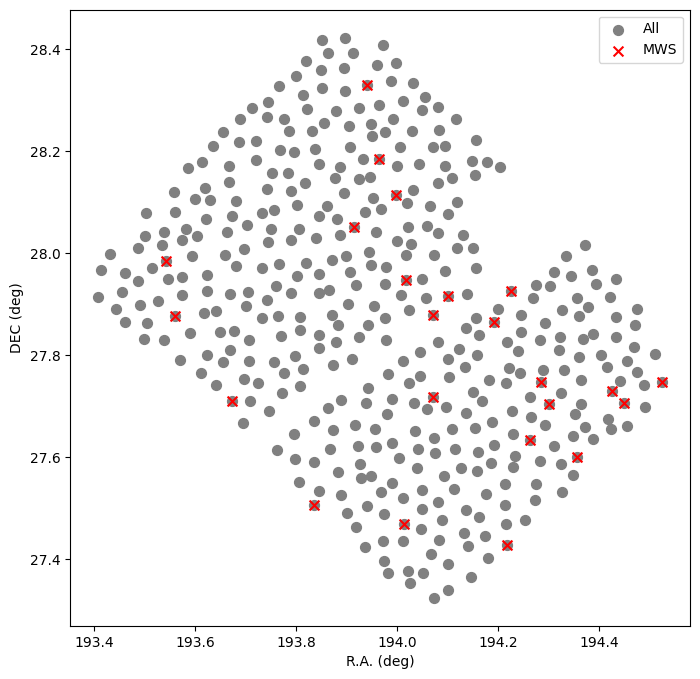

In [52]:
plt.figure(figsize = (8, 8))

plt.scatter(fm['TARGET_RA'], fm['TARGET_DEC'], color = 'grey', s = 50, label = 'All')
plt.scatter(fm['TARGET_RA'][is_mws], fm['TARGET_DEC'][is_mws], color = 'r', s = 50, marker = 'x', label = 'MWS')
plt.xlabel('R.A. (deg)')
plt.ylabel('DEC (deg)')
plt.legend()

### Healpix based redrock file

In [54]:
# Redrock Filename -
z_filename = f'redrock-{survey}-{program}-{hpx}.fits'

In [55]:
h_rr = fits.open(f'{tgt_dir}/{z_filename}')
h_rr.info()
h_rr.close()

Filename: /content/drive//MyDrive/desi_edr_test/fuji/healpix/sv1/dark/104/10400/redrock-sv1-dark-10400.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      71   ()      
  1  REDSHIFTS     1 BinTableHDU     32   413R x 11C   [K, D, D, K, D, 10D, K, 6A, 20A, K, D]   
  2  FIBERMAP      1 BinTableHDU    149   413R x 70C   [K, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, D, E, D, E, E]   
  3  EXP_FIBERMAP    1 BinTableHDU     61   3304R x 26C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D]   
  4  TSNR2         1 BinTableHDU     75   413R x 33C   [K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


The redrock* file has 4 extensions:

* **REDSHIFTS** consists of redshift information and outputs from redrock.
* **FIBERMAP** is similar to the one in coadd* file and has information about the targets.
* **EXP_FIBERMAP** is again similar to the one in the coadd* file and has exposure information about the targets.
* **TSNR2** contains information about the expected SNR measurements for the targets.

Information about the datamodel is [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/redrock-SURVEY-PROGRAM-PIXNUM.html). <br/>
You can in principle use these files directly and write your own code to access the spectra. However, `desispec` also provides a function for accessing the coadded spectra as shown below.

<a class="anchor" id="spectra"></a>
## Working with Coadded Spectra using _desispec.io.read_spectra()_

In [56]:
# Using desispec to read the spectra

coadd_obj = desispec.io.read_spectra(f'{tgt_dir}/{coadd_filename}')
coadd_tgts = coadd_obj.target_ids().data

INFO:spectra.py:386:read_spectra: iotime 0.971 sec to read coadd-sv1-dark-10400.fits at 2023-10-24T04:02:00.717264


INFO:desiutil.log.dlm58.info:iotime 0.971 sec to read coadd-sv1-dark-10400.fits at 2023-10-24T04:02:00.717264


In [57]:
# Selecting the particular spectra of the targetid

row = (coadd_tgts == targetid)
coadd_spec = coadd_obj[row]

In [58]:
coadd_spec.wave

{'b': array([3600. , 3600.8, 3601.6, ..., 5798.4, 5799.2, 5800. ]),
 'r': array([5760. , 5760.8, 5761.6, ..., 7618.4, 7619.2, 7620. ]),
 'z': array([7520. , 7520.8, 7521.6, ..., 9822.4, 9823.2, 9824. ])}

In [59]:
coadd_spec.flux

{'b': array([[11.69297886, 13.55353546, 14.78283691, ..., 11.36130524,
         11.75193214, 11.5271244 ]]),
 'r': array([[14.24016857, 11.67773533, 12.21424103, ...,  7.52396393,
          7.84369993,  7.60911274]]),
 'z': array([[9.65051937, 8.78138447, 8.72062302, ..., 5.07644987, 5.19984436,
         5.01195192]])}

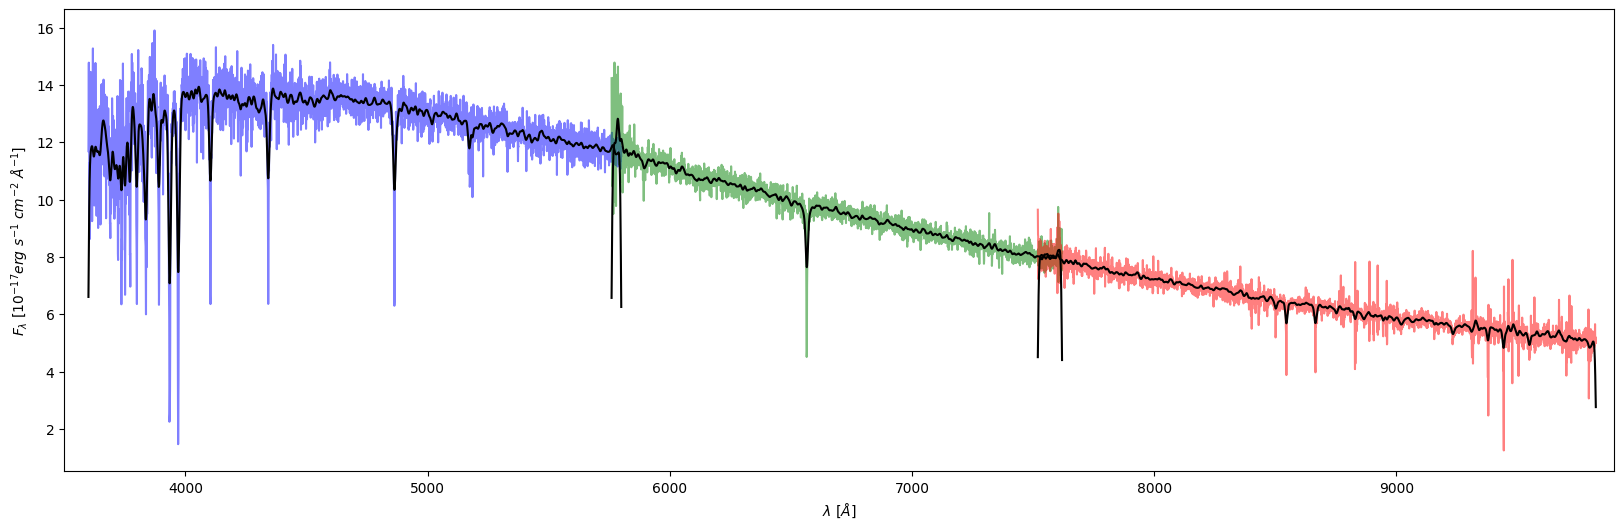

In [60]:
# Plotting this spectra -

plt.figure(figsize = (20, 6))
# Plot the spectrum from each arm (B,R,Z) in blue, green, red

plt.plot(coadd_spec.wave['b'], coadd_spec.flux['b'][0], color = 'b', alpha = 0.5)
plt.plot(coadd_spec.wave['r'], coadd_spec.flux['r'][0], color = 'g', alpha = 0.5)
plt.plot(coadd_spec.wave['z'], coadd_spec.flux['z'][0], color = 'r', alpha = 0.5)
# Over-plotting smoothed spectra in black for all the three arms
plt.plot(coadd_spec.wave['b'], convolve(coadd_spec.flux['b'][0], Gaussian1DKernel(5)), color = 'k')
plt.plot(coadd_spec.wave['r'], convolve(coadd_spec.flux['r'][0], Gaussian1DKernel(5)), color = 'k')
plt.plot(coadd_spec.wave['z'], convolve(coadd_spec.flux['z'][0], Gaussian1DKernel(5)), color = 'k')
plt.xlim([3500, 9900])
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

The coadded spectra available is divided based on the observed (B,R,Z) camera. We can obtain the joint spectrum using the available `coaddition.coadd_cameras` function.

In [61]:

# Combined Spectra -

spec_combined = coaddition.coadd_cameras(coadd_spec)

In [62]:
spec_combined.wave

{'brz': array([3600. , 3600.8, 3601.6, ..., 9822.4, 9823.2, 9824. ])}

In [63]:
spec_combined.flux

{'brz': array([[11.69297886, 13.55353546, 14.78283691, ...,  5.07644987,
          5.19984436,  5.01195192]])}

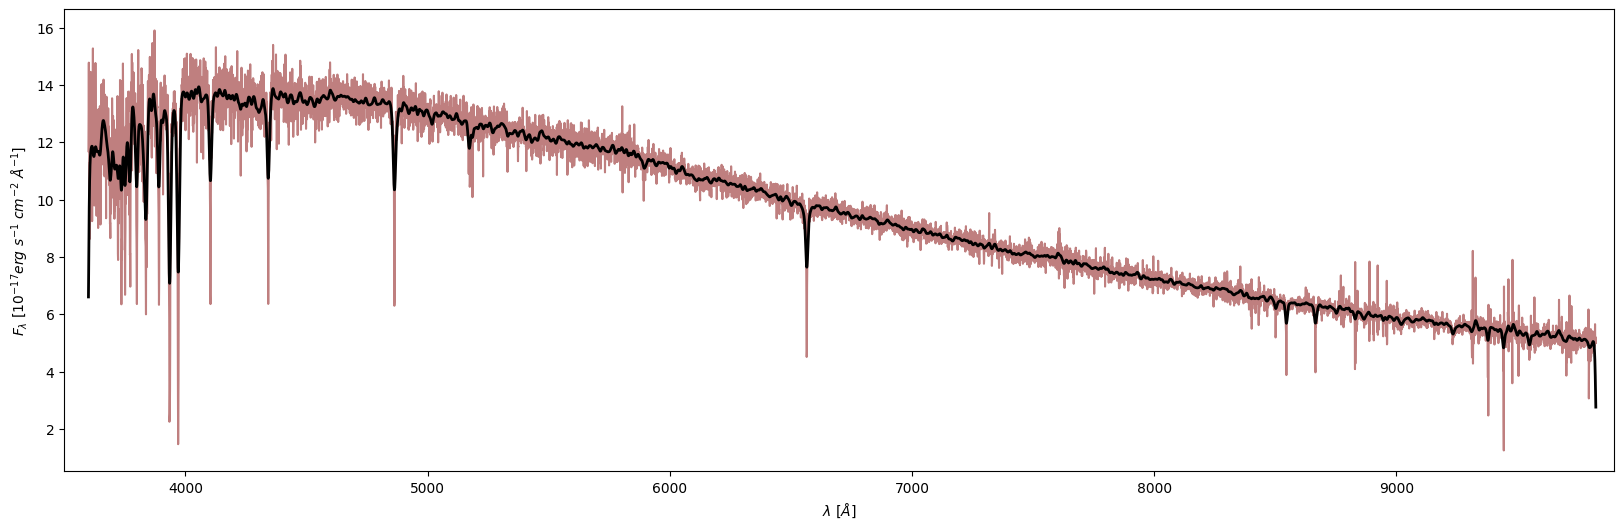

In [64]:
# Plotting this combined spectra -

# Plotting this spectra -

plt.figure(figsize = (20, 6))
# Plot the combined spectrum in maroon
plt.plot(spec_combined.wave['brz'], spec_combined.flux['brz'][0], color = 'maroon', alpha = 0.5)
# Over-plotting smoothed spectra
plt.plot(spec_combined.wave['brz'], convolve(spec_combined.flux['brz'][0], Gaussian1DKernel(5)), color = 'k', lw = 2.0)
plt.xlim([3500, 9900])
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

Let us now plot some of the spectra available for this object.

2
downloading coadd file from https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/healpix/sv1/bright/104/10400/coadd-sv1-bright-10400.fits to /content/drive//MyDrive/desi_edr_test//fuji/healpix/sv1/bright/104/10400/coadd-sv1-bright-10400.fits
INFO:spectra.py:386:read_spectra: iotime 2.997 sec to read coadd-sv1-bright-10400.fits at 2023-10-24T04:02:31.813202


INFO:desiutil.log.dlm58.info:iotime 2.997 sec to read coadd-sv1-bright-10400.fits at 2023-10-24T04:02:31.813202


/content/drive//MyDrive/desi_edr_test//fuji/healpix/sv1/dark/104/10400/coadd-sv1-dark-10400.fits present on disk. 
INFO:spectra.py:386:read_spectra: iotime 0.601 sec to read coadd-sv1-dark-10400.fits at 2023-10-24T04:02:33.133357


INFO:desiutil.log.dlm58.info:iotime 0.601 sec to read coadd-sv1-dark-10400.fits at 2023-10-24T04:02:33.133357


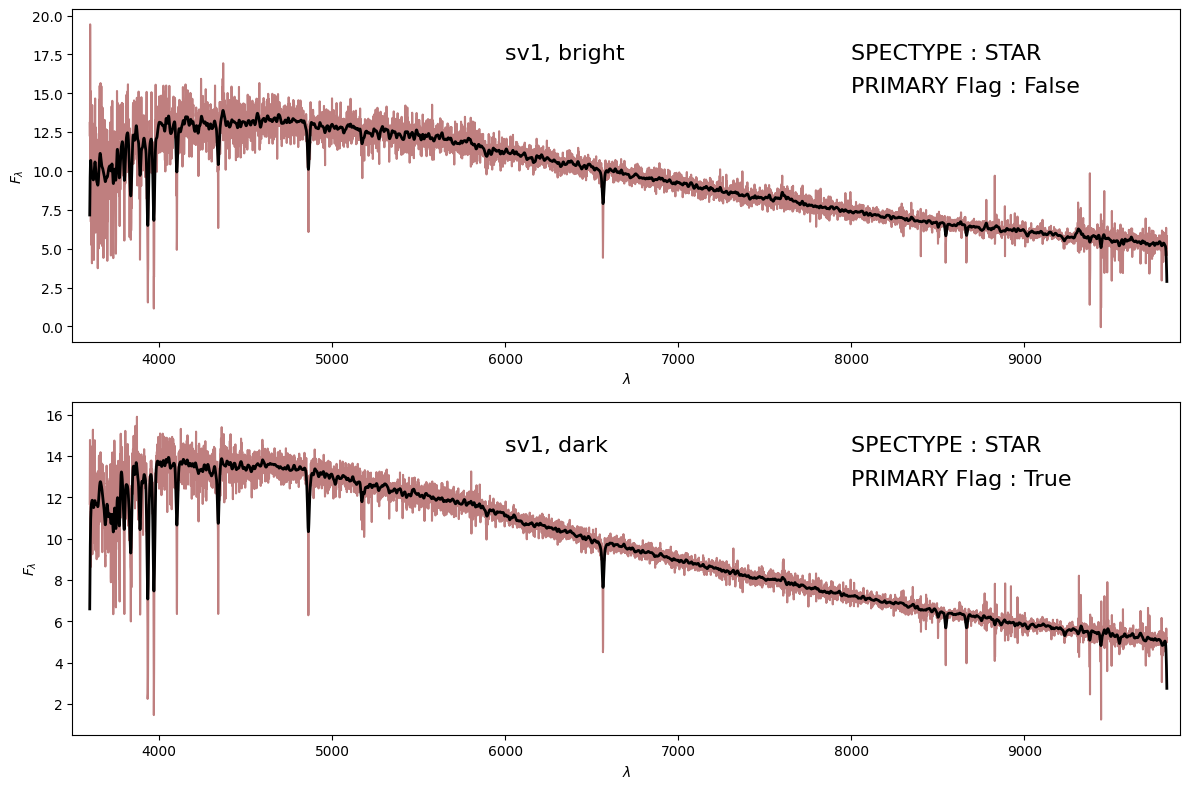

In [65]:
# Number of spectra
n = 2 #len(zcat_sel) #Due to memory issues to be solved we only display 2 instead of all
print(n)
fig, ax = plt.subplots(n, 1, figsize = (12,(4*n)))

for jj in range(n):
    survey = survey_col[jj]
    program = program_col[jj]
    hpx = hpx_col[jj]

    spectype = zcat_sel['SPECTYPE'].astype(str).data[jj]
    primary_flag = zcat_sel['ZCAT_PRIMARY'].data[jj]

    tgt_dir = f'{healpix_dir}/{survey}/{program}/{hpx//100}/{hpx}'
    coadd_filename = f'coadd-{survey}-{program}-{hpx}.fits'
    get_spec_data_url(hpx,survey,program)
    coadd_obj = desispec.io.read_spectra(f'{tgt_dir}/{coadd_filename}')
    coadd_tgts = coadd_obj.target_ids().data
    row = (coadd_tgts == targetid)
    coadd_spec = coadd_obj[row]

    spec_combined = coaddition.coadd_cameras(coadd_spec)

    # Plot the combined spectrum in maroon
    ax[jj].plot(spec_combined.wave['brz'], spec_combined.flux['brz'][0], color = 'maroon', alpha = 0.5)
    # Over-plotting smoothed spectra
    ax[jj].plot(spec_combined.wave['brz'], convolve(spec_combined.flux['brz'][0], Gaussian1DKernel(5)), color = 'k', lw = 2.0)
    ax[jj].set(xlim = [3500, 9900], xlabel = '$\lambda$', ylabel = '$F_{\lambda}$')

    trans = ax[jj].get_xaxis_transform()
    ax[jj].annotate(f'{survey}, {program}', xy = (6000, 0.85), xycoords = trans, fontsize = 16)
    ax[jj].annotate(f'SPECTYPE : {spectype}', xy = (8000, 0.85), xycoords = trans, fontsize = 16)
    ax[jj].annotate(f'PRIMARY Flag : {primary_flag}', xy = (8000, 0.75), xycoords = trans, fontsize = 16)

plt.tight_layout()

Redrock uses a set of templates to classify sources and find their redshifts. You can use the zbest fit coefficients with the redrock-templates to compare the spectra to the best-fit template. A tutorial on how to do this is available [here](https://github.com/desihub/tutorials/blob/main/redrock/RedrockOutputs.ipynb).

<a class="anchor" id="ref"></a>
# References

* DESI experiment paper: https://arxiv.org/abs/1611.00036
* Information about EDR: https://data.desi.lbl.gov/public/edr
* Information about Survey Validation: https://desi.lbl.gov/trac/wiki/SurveyValidation (**link exclusive to DESI collaborators**)
* Targetting Information:
    * [SV1](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SurveyValidation) (**link exclusive to DESI collaborators**)
    * [SV2](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV2) (**link exclusive to DESI collaborators**)
    * [SV3](https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV3) (**link exclusive to DESI collaborators**)
    * [main](https://ui.adsabs.harvard.edu/abs/2023AJ....165...50M/abstract) survey
* Datamodel information: https://desidatamodel.readthedocs.io/en/latest/
    * [tiles-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/tiles-SPECPROD.html)
    * [exposures-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/exposures-SPECPROD.html)
    * [Redshift catalogs](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/index.html)
    * [zall-pix-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-pix-SPECPROD.html)
    * [zall-tilecumulative-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-tilecumulative-SPECPROD.html)
    * [zpix-SURVEY-PROGRAM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html)
    * [ztile-SURVEY-PROGRAM-GROUPTYPE.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html)
    * [coadd-SURVEY-PROGRAM-PIXNUM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/coadd-SURVEY-PROGRAM-PIXNUM.html)
    * [redshift-SURVEY-PROGRAM-PIXNUM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/redrock-SURVEY-PROGRAM-PIXNUM.html)
* Information about DESI bitmasks: https://desidatamodel.readthedocs.io/en/latest/bitmasks.html
* Redrock Template Tutorial: https://github.com/desihub/tutorials/blob/main/redrock/RedrockOutputs.ipynb